# Launch node RCA

In [44]:
# Import the goods.
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Machine Learning Tools
from sklearn import preprocessing
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Supervised Classifiers
from sklearn.neighbors import KNeighborsClassifier

#Decision Tree
from sklearn import tree

%matplotlib inline 

In [2]:
# Load and normalize the data set.
allocation_data="/u/jdunham/csm_allocation.json"

allocations=[]
with open(allocation_data,'r') as aFile:
    for line in aFile:
        allocations.append(json.loads(line)["data"])
df_allocation=json_normalize(allocations)       



df_allocation.head(5)



,account,allocation_id,archive_history_time,begin_time,comment,end_time,exit_status,history_time,isolated_cores,job_name,...,system_flags,time_limit,type,user_flags,user_group_id,user_group_name,user_id,user_name,user_script,wc_key
0,CSC190RAPTOR,142874,None,2019-01-01 02:00:08.649555,,2019-01-01 02:10:57.105669,0,2019-01-01 02:10:57.105669,1,raptorxlf,...,,3600,jsm-cgroup-step,gpumps,1099,None,58914,rsankar,user script not known by LSF,
1,PHY131,142875,None,2019-01-01 02:36:23.900649,,2019-01-01 02:36:54.909384,0,2019-01-01 02:36:54.909384,1,a,...,,600,jsm-cgroup-step,gpumps,25848,None,14522,jiquntu,user script not known by LSF,
2,PHY131,142876,None,2019-01-01 02:37:14.131562,,2019-01-01 02:37:45.118999,0,2019-01-01 02:37:45.118999,1,a,...,,600,jsm-cgroup-step,gpumps,25848,None,14522,jiquntu,user script not known by LSF,
3,PHY131,142877,None,2019-01-01 02:38:17.875792,,2019-01-01 02:38:48.610066,0,2019-01-01 02:38:48.610066,1,a,...,,600,jsm-cgroup-step,gpumps,25848,None,14522,jiquntu,user script not known by LSF,
4,PHY131,142878,None,2019-01-01 02:39:27.665711,,2019-01-01 02:39:59.121107,0,2019-01-01 02:39:59.121107,1,a,...,,600,jsm-cgroup-step,gpumps,25848,None,14522,jiquntu,user script not known by LSF,


In [3]:
# Print Columns
df_allocation.columns

Index(['account', 'allocation_id', 'archive_history_time', 'begin_time',
       'comment', 'end_time', 'exit_status', 'history_time', 'isolated_cores',
       'job_name', 'job_submit_time', 'job_type', 'launch_node_name',
       'num_gpus', 'num_nodes', 'num_processors', 'primary_job_id',
       'projected_memory', 'queue', 'requeue', 'secondary_job_id',
       'ssd_file_system_name', 'ssd_max', 'ssd_min', 'state', 'system_flags',
       'time_limit', 'type', 'user_flags', 'user_group_id', 'user_group_name',
       'user_id', 'user_name', 'user_script', 'wc_key'],
      dtype='object')

In [4]:
# Create dummies DON'T RE-RUN!
state_df    = pd.get_dummies(df_allocation["state"],prefix="state")
launch_df   = pd.get_dummies(df_allocation["launch_node_name"], prefix="launch")
job_type_df = pd.get_dummies(df_allocation["job_type"], prefix="job_type")

# Cache generated cell names.
state_cols    = state_df.columns
launch_cols   = launch_df.columns
job_type_cols = job_type_df.columns

# Update the base data frame.
df_allocation = pd.concat([df_allocation, launch_df,job_type_df,state_df], axis=1)
df_allocation.drop(["state","exit_status","comment","job_name","launch_node_name","job_type"], axis = 1, inplace=True)

# Fix timestamps, convert to epoch time for analysis.
df_allocation['begin_time'] = pd.to_datetime(df_allocation['begin_time'], format='%Y-%m-%d %H:%M:%S.%f').astype(np.int64)
df_allocation['end_time']   = pd.to_datetime(df_allocation['end_time'], format='%Y-%m-%d %H:%M:%S.%f').astype(np.int64)
df_allocation.drop(["history_time","archive_history_time","user_script","wc_key","user_group_name"], 
                   axis = 1, inplace=True)
df_allocation.dtypes



account                 object
allocation_id            int64
begin_time               int64
end_time                 int64
isolated_cores           int64
job_submit_time         object
num_gpus                 int64
num_nodes                int64
num_processors           int64
primary_job_id           int64
projected_memory         int64
queue                   object
requeue                 object
secondary_job_id         int64
ssd_file_system_name    object
ssd_max                  int64
ssd_min                  int64
system_flags            object
time_limit               int64
type                    object
user_flags              object
user_group_id            int64
user_id                  int64
user_name               object
launch_batch1            uint8
launch_batch2            uint8
launch_batch3            uint8
launch_batch4            uint8
launch_batch5            uint8
job_type_batch           uint8
job_type_interactive     uint8
state_complete           uint8
state_fa

# Correlations

The following is a limited correlation to get a rough idea of what's going on with the data.

In [5]:
cols=["primary_job_id","num_nodes","time_limit","user_id"]
cols.extend(state_cols)
cols.extend(launch_cols)
cols.extend(job_type_cols)

groups      = df_allocation[cols]
correlation = groups.corr()
correlation

,primary_job_id,num_nodes,time_limit,user_id,state_complete,state_failed,launch_batch1,launch_batch2,launch_batch3,launch_batch4,launch_batch5,job_type_batch,job_type_interactive
primary_job_id,1.000000,-0.016434,0.022211,0.049077,0.011573,-0.011573,-0.045647,-0.024198,-0.033019,0.003317,0.099266,0.073139,-0.073139
num_nodes,-0.016434,1.000000,0.088857,0.054204,-0.042422,0.042422,0.020447,-0.004725,0.003337,-0.009479,-0.012476,0.042440,-0.042440
time_limit,0.022211,0.088857,1.000000,-0.017239,-0.025191,0.025191,0.006983,0.000896,-0.003533,-0.002659,-0.002187,0.106877,-0.106877
user_id,0.049077,0.054204,-0.017239,1.000000,-0.039853,0.039853,-0.003608,-0.002854,-0.002663,-0.004686,0.013157,-0.013485,0.013485
state_complete,0.011573,-0.042422,-0.025191,-0.039853,1.000000,-1.000000,0.007951,-0.006920,0.000659,0.001397,-0.004472,0.013804,-0.013804
state_failed,-0.011573,0.042422,0.025191,0.039853,-1.000000,1.000000,-0.007951,0.006920,-0.000659,-0.001397,0.004472,-0.013804,0.013804
launch_batch1,-0.045647,0.020447,0.006983,-0.003608,0.007951,-0.007951,1.000000,-0.237981,-0.312923,-0.259464,-0.306865,-0.010059,0.010059
launch_batch2,-0.024198,-0.004725,0.000896,-0.002854,-0.006920,0.006920,-0.237981,1.000000,-0.217817,-0.180605,-0.213600,-0.001686,0.001686
launch_batch3,-0.033019,0.003337,-0.003533,-0.002663,0.000659,-0.000659,-0.312923,-0.217817,1.000000,-0.237479,-0.280864,0.003997,-0.003997
launch_batch4,0.003317,-0.009479,-0.002659,-0.004686,0.001397,-0.001397,-0.259464,-0.180605,-0.237479,1.000000,-0.232882,0.010455,-0.010455


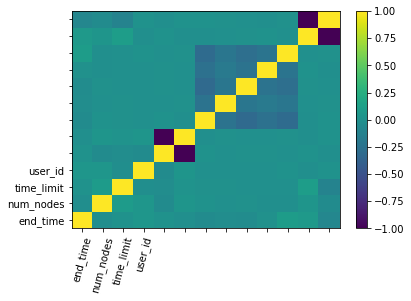

In [45]:
# Generate the correlation heat map and axis
fig, ax = plt.subplots()
hm = plt.pcolor(correlation)

# Move ticks and labels to the center
ax.set_xticks(np.arange(groups.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(groups.shape[1]) + 0.5, minor=False)

# Insert labels
ax.set_xticklabels(cols, minor=False)
ax.set_yticklabels(cols, minor=False)

# Rotate label
plt.xticks(rotation=75)

# Plot the color guide and show the correlation
plt.colorbar()
plt.show()

## Assessment of the Correlation

Looks like there's a _slight_ positive correlation between *state_failed* : 
- *num_nodes*
    - More nodes == more failure rate? (makes sense)
- *time_limit*
    - Longer jobs fail more.
- *user_id*
    - This is a coincidental correlation as userid value does *not* have numeric value.

We know that there was an instance in which *user_id* and *launch_{node}* had a correlation with *state_failed*. An extremely rough way of looking at it is:

``` math
user_id + launch_{node} = state_failed
```

However, RCA indicated that this was an SSH key problem on the node. A "runtime" test might catch something like this easily, but we should see if it's possible to design some kind of static analysis to find this.

There are other possible "combination failures" that might manifest as well. This might actually be a phenomenal case for a Map-Reduce resolution, but let's see if there's any math we can do here.


---

Unfortunately it looks like a basic linear regression model is not going to help us a lot on this one. As the event is time series sensitive and related to the configuration of the nodes abstracted in this data.

It looks like all of the launch node correlations are functionally worthless, note the blue square of negative correlations. The only thing we can learn from this is recent jobs have been running on *launch_batch5*.

It looks like to properly train this data we're going to need to use time series.


## Planning

We need to know when failures were happening. First lets plot the *state_failed* count against *end_time*. I'm going to bin the time series to make the data a little more manageable.


In [7]:
# Generate the time series grouping, this is Weekly.
#df_allocation_ts = df_allocation.groupby(pd.Grouper(key='end_time',freq="w"))


In [8]:
#df_allocation_ts[["state_failed"]].sum().plot()
#df_allocation_ts[["num_nodes"]].mean().plot()

## Time Series Assesment

Looks like maybe we need a decision tree?

Market basket analysis or clustering might be good?



In [9]:
# TODO HOW  DO I INCORP
cols=["end_time","num_nodes","time_limit","user_id"]
# removing this introduces more false positives, but it catches more failures.
#cols.extend(launch_cols)

#a_classifier=tree.DecisionTreeClassifier()
#a_classifier.fit(df_allocation_ts[cols],df_allocation_ts["end_time"])

X=df_allocation[cols].values
Y=df_allocation["state_failed"].values

# Normalize the data to help the K-Neighbors util.
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float)) 


/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
# Grab 20% of the data for testing,  
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (60955, 4) (60955,)
Test set: (15239, 4) (15239,)


In [11]:
# Let's try K neighbors first:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [12]:
yhat = neigh.predict(X_test)


# K-neighbors
It looks like we have a decent accuracy with this model. It's basically 100% accurate, meaning with decent accuracy we might be able to compute the likelihood of a node going down with K-Nearest Neighbors. 


That being said, for RCA, it's functionally worthless.

In [13]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9979000902304979
Test set Accuracy:  0.9980313668875911


In [14]:
predicted_failures = np.where(yhat == 1)
actual_failures = np.where(y_test == 1)

In [15]:
print ("   actual: ", actual_failures)
print ("predicted: ",predicted_failures)

   actual:  (array([  417,   527,   551,  1246,  3162,  3441,  3921,  4697,  6479,
        6868,  6942,  7230,  7379,  7954,  8192,  8283,  8594,  8681,
        9244, 10393, 10683, 11420, 13314, 13645, 14526, 14538, 14736,
       14769, 14821, 14866, 14889, 15120, 15194]),)
predicted:  (array([ 2062,  3441,  5311,  5938,  6942,  7230,  9244,  9421, 14538,
       14736, 14769]),)


In [16]:
df_allocation[df_allocation["state_failed"] == 1].head()

,account,allocation_id,begin_time,end_time,isolated_cores,job_submit_time,num_gpus,num_nodes,num_processors,primary_job_id,...,user_name,launch_batch1,launch_batch2,launch_batch3,launch_batch4,launch_batch5,job_type_batch,job_type_interactive,state_complete,state_failed
5,CSC190HACC,142857,1546274195651857000,1546319048020210000,1,2018-12-31 16:04:37,0,4096,0,230304,...,heitmann,0,0,1,0,0,1,0,0,1
466,CSC190HACC,143341,1546493626492423000,1546495378352979000,1,2019-01-03 05:33:43,0,4096,0,230807,...,nfrontie,1,0,0,0,0,1,0,0,1
1495,PHY122,144373,1546638394601160000,1546639612980280000,1,2019-01-04 21:43:21,0,32,0,231873,...,worley,0,0,1,0,0,1,0,0,1
1524,CSC190HACC,143999,1546599242658555000,1546681656370835000,1,2019-01-04 10:53:59,0,4096,0,231468,...,heitmann,1,0,0,0,0,1,0,0,1
4949,BIP115,147795,1547051918968357000,1547056140642049000,1,2019-01-09 16:38:32,0,64,0,235096,...,jimp,0,0,0,1,0,1,0,0,1


In [17]:
f_series = df_allocation.ix[actual_failures]
f_series.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,account,allocation_id,begin_time,end_time,isolated_cores,job_submit_time,num_gpus,num_nodes,num_processors,primary_job_id,...,user_name,launch_batch1,launch_batch2,launch_batch3,launch_batch4,launch_batch5,job_type_batch,job_type_interactive,state_complete,state_failed
417,STF007,143293,1546450448924237000,1546450536509951000,1,2019-01-02 17:34:02,0,8,0,230754,...,gmarkoma,0,0,0,1,0,1,0,1,0
527,VEN013,143408,1546511495270874000,1546511600896445000,1,2019-01-03 10:31:23,0,1,0,230874,...,xaviero,0,0,0,1,0,0,1,1,0
551,MED107,143435,1546513214834387000,1546513227017380000,1,2019-01-03 11:00:05,0,1,0,230920,...,gounley1,0,0,0,1,0,1,0,1,0
1246,STF007,144123,1546605890335351000,1546605902024109000,1,2019-01-04 12:42:13,0,1,0,231593,...,jackm,1,0,0,0,0,1,0,1,0
3162,STF006ACCEPT,146038,1546890908862634000,1546890923388614000,1,2019-01-07 19:55:06,0,2,0,233363,...,arnoldt,0,0,1,0,0,1,0,1,0


# Changing Gears

At this point using labelled data is not really giving us much progress. We have a first pass failure dector, but it's somewhat limited. I'm not convinced that this is giving us the data we really want and the error case we're looking for doesn't manifest. 

## Restate the problem

A user's ssh key was not properly configured on launch node 5. This resulted in the job being deleted (successfully) and the job being re-scheduled by LSF. The following features were meaningful in this RCA:

 * user_id
  - Name is not needed, as we have a scalar by default.
  - This might not even be needed, as the primary job id was the main identifier.
 * primary_job_id
  - ID of the job that was rescheduled.
  - This could be an input to a script.
 * launch_node
  - Categorical entry.
  - This was in common across runs.
 * begin_time
  - The begin time is needed for rapid retry detection.

The output to an assesment of these features could be considered a clustering, e.g. properly configured ssh improperly configured ssh.

<!-- This is almost an inverse DBSCAN?-->

Since the data is labelled it looks like classification is the best case. That being said we want to find outliers with tight grouping.

Really we can do this with two features *primary_job_id* and *launch_node*.

Let's modify the approach, first we should condense the feature set to just *launch_node*.




In [18]:
df_launch =   df_allocation[launch_cols].dot(range(0,len(launch_cols)))
df_launch.name = "launch_node"
df_launch = pd.concat([df_launch, df_allocation[["primary_job_id", "user_id", "user_name", "begin_time"]]], axis=1)
print(launch_cols)
df_launch.head(5)


Index(['launch_batch1', 'launch_batch2', 'launch_batch3', 'launch_batch4',
       'launch_batch5'],
      dtype='object')


,launch_node,primary_job_id,user_id,user_name,begin_time
0,0,230215,58914,rsankar,1546308008649555000
1,1,230325,14522,jiquntu,1546310183900649000
2,0,230326,14522,jiquntu,1546310234131562000
3,4,230327,14522,jiquntu,1546310297875792000
4,4,230328,14522,jiquntu,1546310367665711000


In [30]:
counts=df_launch["primary_job_id"].value_counts()
bad_jobs=counts[counts>5].keys()

launch_group= df_launch[df_launch["primary_job_id"].isin(bad_jobs)].groupby(['primary_job_id',"launch_node"])

launch_group.size().head(5)

primary_job_id  launch_node
229289          1              2
                2              5
                4              3
232526          0              8
                2              1
dtype: int64

<IPython.core.display.Javascript object>


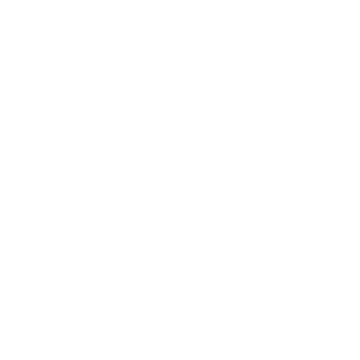

<IPython.core.display.Javascript object>


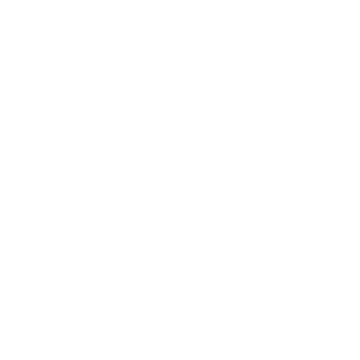

In [42]:
sns.lmplot('launch_node', 'primary_job_id', data=df_launch[df_launch["primary_job_id"].isin(bad_jobs)], fit_reg=False)


IndexError: Column(s) ['launch_node', 'primary_job_id'] already selected

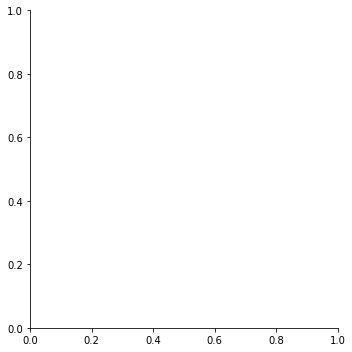